# Imports and constants

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from Metrics import compute_metrics, make_metric_plots
import visualizer.Viewer as vw
from models.time_series.anomaly.machine_learning.TimeSeriesAnomalyIForest import TimeSeriesAnomalyIForest
from reader.NABTimeSeriesReader import NABTimeSeriesReader

# DATASET 1: ambient_temperature_system_failure
# DATASET 2: nyc_taxi
DATASET_PATH = "data/dataset/"
DATASET = "nyc_taxi.csv"
PURE_DATA_KEY = "realKnownCause/nyc_taxi.csv"
GROUND_WINDOWS_PATH = "data/dataset/combined_windows.json"
CHECK_OVERFITTING = False
ALL_DATA = False

def preprocess(X) -> np.ndarray:
    return StandardScaler().fit_transform(X)

# Read the dataset and train-test split

In [2]:
reader = NABTimeSeriesReader(DATASET_PATH)
all_df = reader.read(DATASET_PATH + DATASET).get_dataframe()
training, test = reader.train_test_split(train_perc=0.37).get_train_test_dataframes()

# Data used to train
data = preprocess(np.array(training["value"]).reshape((training["value"].shape[0], 1)))
data_labels = training["target"]

# Data used to test
data_test = preprocess(np.array(test["value"]).reshape((test["value"].shape[0], 1)))
data_test_labels = test["target"]

# Dataframe used to evaluate
dataframe = test.copy()
dataframe["value"] = data_test

train = data

if CHECK_OVERFITTING:
    data_test = data
    data_test_labels = data_labels
    dataframe = training.copy()
    dataframe["value"] = data_test
elif ALL_DATA:
    data_test = preprocess(np.array(all_df["value"]).reshape(all_df["value"].shape[0], 1))
    data_test_labels = all_df["target"]
    dataframe = all_df.copy()
    dataframe["value"] = data_test

# Create model, classify and score

In [3]:
model = TimeSeriesAnomalyIForest(window=5,
                                 # n_estimators=100,
                                 contamination=0.004,
                                 # max_samples=30,
                                 random_state=22)
model.fit(train)

true_labels = data_test_labels

labels = model.classify(data_test.reshape((-1, 1)))
scores = model.anomaly_score(data_test.reshape((-1, 1)))

# Evaluation metrics for anomaly detection

In [4]:
compute_metrics(true_labels, scores, labels, only_roc_auc=False)

ACCURACY SCORE:  0.9980003076449777
PRECISION SCORE:  0.1
RECALL SCORE:  0.2
F1 SCORE:  0.13333333333333333
AVERAGE PRECISION SCORE:  0.22393111109051406
PRECISION-RECALL AUC SCORE:  0.21926227522503886
AUROC SCORE:  0.8147475369458128


# Confusion matrix

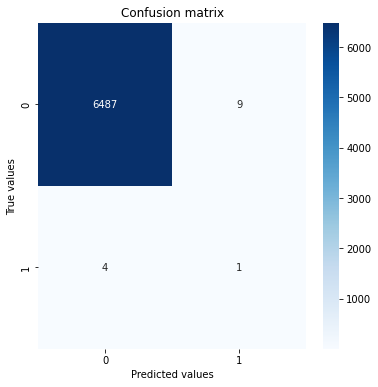

In [5]:
confusion_matrix = metrics.confusion_matrix(true_labels, labels)
vw.plot_confusion_matrix(confusion_matrix)

# ROC curve

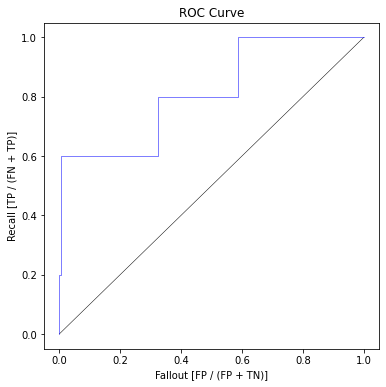

In [6]:
vw.plot_roc_curve(true_labels, scores)

# Precision-recall curve

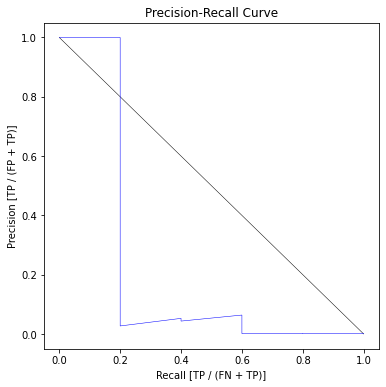

In [7]:
vw.plot_precision_recall_curve(true_labels, scores)

# Assigned labels

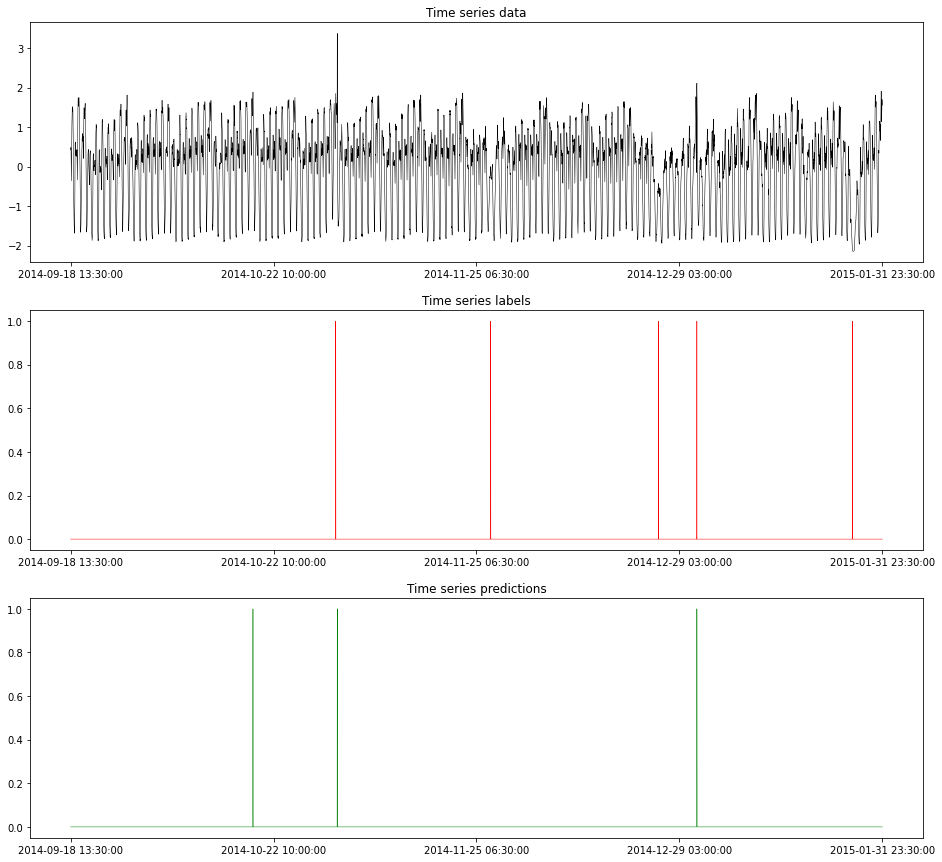

In [8]:
vw.plot_univariate_time_series_predictions(dataframe, labels)

# Assigned scores

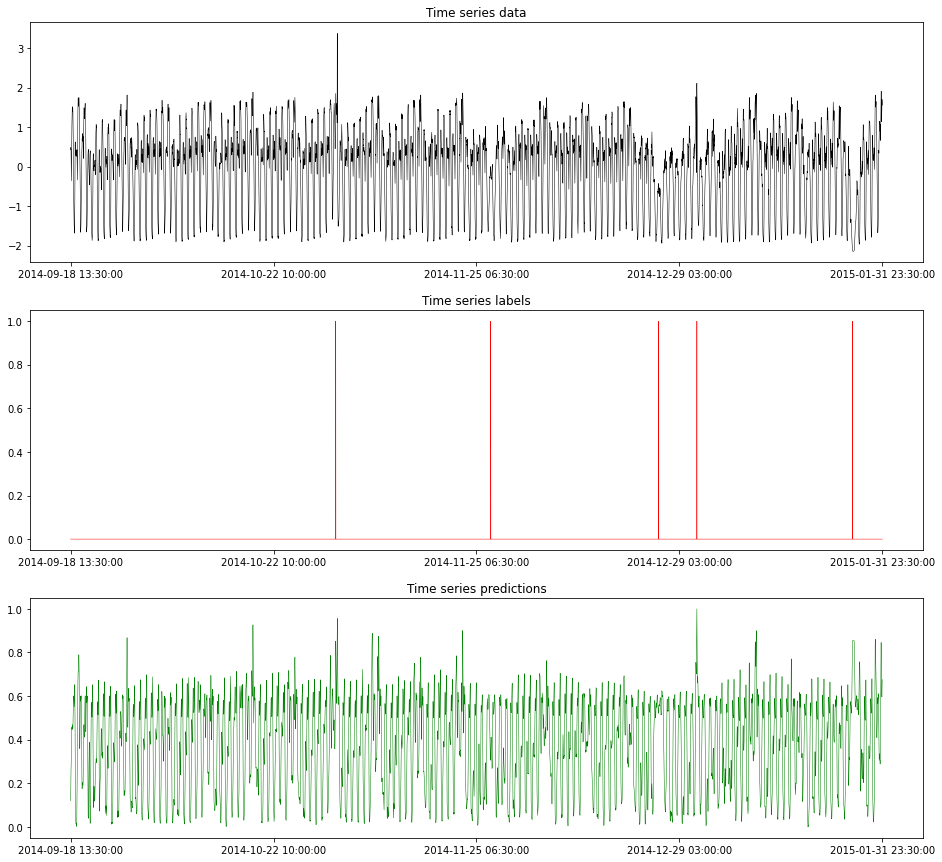

In [9]:
vw.plot_univariate_time_series_predictions(dataframe, scores)

# Anomalies predictions as red dots

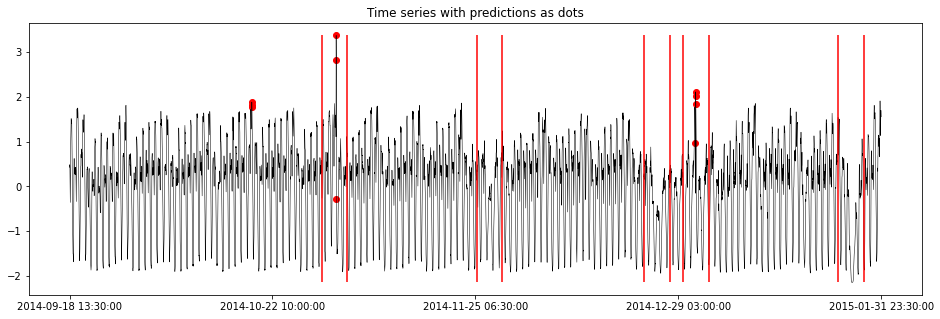

In [10]:
bars = vw.get_bars_indices_on_test_df(all_df,
                                      dataframe,
                                      PURE_DATA_KEY,
                                      GROUND_WINDOWS_PATH)
vw.plot_time_series_with_predicitons_bars(dataframe,
                                          labels,
                                          bars,
                                          pred_color='r')